# HW3: Online Hindsight Experience Replay

В данном домашнем задании вам предстоит реализовать [online HER](https://arxiv.org/abs/1802.09464) (напомним, оригинальная [статья HER](https://arxiv.org/abs/1707.01495)) для базового алгоритма [DDPG](https://arxiv.org/abs/1509.02971) в задаче [FetchReach](https://robotics.farama.org/envs/fetch/reach/).

Цель обучения агента — научиться достигать произвольной точки в пространстве, которая задаётся средой (на изображении ниже — это красный шарик). Вознаграждение отлично от `-1` только в том случае, если манипулятор оказался в малой окрестности цели. Это означает, что положительное подкрепление можно получить лишь в редких случаях — когда агенту случайно удаётся точно попасть в цель. Объём "полезных" (целевых) состояний оказывается существенно меньше объёма всего пространства достижимых состояний (сравните объём красного шарика с областью, куда вообще может дотянуться рука). В начальной фазе обучения это особенно критично: стратегия агента ещё не умеет достигать целей, и положительное подкрепление почти не поступает.

Для решения этой проблемы методы семейства HER предлагают модифицировать переходы, добавляемые в буфер воспроизведения: часть из них можно "переосмыслить", подменив исходную (не достигнутую) цель на одну из целей, которых агент фактически достиг в этом эпизоде. Такие цели называются **достигнутыми** — то есть агент "посетил" соответствующее состояние в процессе взаимодействия со средой. Это позволяет "спасать" эпизоды, которые не достигли исходной цели, и превращать их в полезные тренировочные примеры. Подробнее о механике HER — ниже.

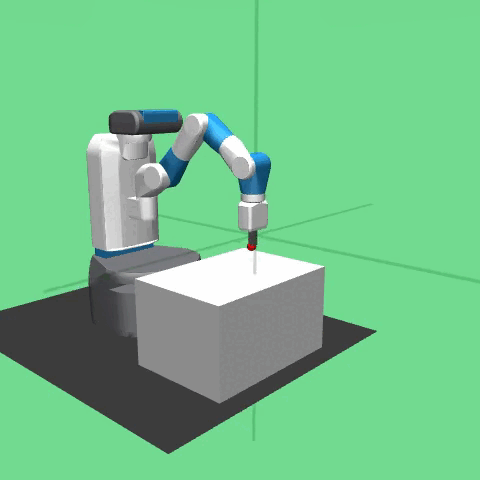

В отличие от классических RL-сред, целенаправленные среды в `gymnasium` при вызове методов `.reset()` и `.step()` возвращают не вектор наблюдения, а словарь, содержащий три ключа: `'observation'`, `'achieved_goal'` и `'desired_goal'`.

- `'observation'` — как и раньше, содержит векторное описание наблюдения (в данном случае — положения и скорости сочленений);
- `'achieved_goal'` — векторное представление цели, которой агент фактически достиг на данном шаге;
- `'desired_goal'` — вектор цели, заданной средой.

В семинаре пространства целей и наблюдений совпадали. В случае текущей среды `FetchReach`, пространство целей — это координаты гриппера манипулятора. То есть `'achieved_goal'` содержит текущее положение гриппера, а `'desired_goal'` — его желаемое целевое положение. Именно за достижение этой точки агент получает вознаграждение `0`.

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass
if COLAB:
    !pip install -q matplotlib
    !pip install -q numpy
    !pip install -q wandb
    !pip install -q tyro
    !pip install -q tensorboard
    !pip install -q scikit-learn
    !pip install -q tqdm
    !pip install -q moviepy
    !pip install -q imageio
    !pip install -q gymnasium
    !pip install -q gymnasium-robotics
    !pip install -q gymnasium[mujoco]
    !pip install -q torch
    !pip install -q torchvision
    !pip install -q torchaudio

In [14]:
import os
os.environ['WANDB_API_KEY'] = 'your_wandb_key'
# check it's correct
!wandb login

## Agent architecture

В этом разделе мы объявим необходимые вспомогательные классы: `ConvertedSigmoid` — для приведения выхода модели к диапазону, соответствующему пространству действий, и `MLP` — для задания сетей актора и критика в алгоритме DDPG.

In [15]:
import torch
from torch import nn

class ConvertedSigmoid(nn.Module):
    # Convert segment from [0; 1] to [low_bound; high_bound]
    def __init__(self, low_bound, high_bound):
        super(ConvertedSigmoid, self).__init__()
        self.low_bound = torch.tensor(low_bound)
        self.scale = torch.tensor(high_bound - low_bound)

    def forward(self, inp):
        return torch.sigmoid(inp) * self.scale.to(inp.device) + self.low_bound.to(inp.device)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dims,
                 activation = nn.ReLU, output_activation = nn.Identity()):
        super(MLP, self).__init__()
        if isinstance(hidden_dims, int):
            hidden_dims = [hidden_dims]

        input_lin = nn.Sequential(nn.Linear(input_dim, hidden_dims[0]), activation())

        if len(hidden_dims) > 1:
            intermediate_mlp = [nn.Sequential(nn.Linear(hidden_input_dim, hidden_output_dim), activation()) for \
                                hidden_input_dim, hidden_output_dim in zip(hidden_dims[:-1], hidden_dims[1:])]

        output_lin = nn.Sequential(nn.Linear(hidden_dims[-1], output_dims), output_activation)
        self.mlp = nn.Sequential(input_lin, *intermediate_mlp, output_lin)

    def forward(self, batch):
        return self.mlp(batch)

## DDPG

Ниже представлена реализация стандартного DDPG для классических RL-сред, а также его адаптация для целеобусловленных задач — `GoalDDPG`. В дальнейших экспериментах мы будем использовать только `GoalDDPG`, однако обе версии приведены здесь для наглядного сравнения их различий.

In [16]:
class DDPG(nn.Module):
    def __init__(self, obs_dim, min_action_values, max_action_values, hidden_dims,
                 exploration_std, gamma,
                 target_exponential_averaging, device):
        super(DDPG, self).__init__()
        self.device = device
        # Discount gamma
        self.gamma = gamma
        # Exponential averaging for target network updates
        self.target_exponential_averaging = target_exponential_averaging
        # Ammount of exploration noise, added to actions
        self.exploration_std = exploration_std
        # Action range in environment
        action_dim = min_action_values.shape
        self.min_action_values = torch.tensor(min_action_values).to(self.device)
        self.max_action_values = torch.tensor(max_action_values).to(self.device)

        assert len(obs_dim) == 1, 'Obs dim must be flat'
        assert len(action_dim) == 1, 'Action dim must be flat'
        # Initialise critic and target_critic as same networks
        self.critic, self._target_critic = [MLP(obs_dim[0] + action_dim[0], hidden_dims, 1).to(device) for i in range(2)]
        self.actor, self._target_actor = [MLP(obs_dim[0], hidden_dims, action_dim[0],
                         output_activation=ConvertedSigmoid(min_action_values, max_action_values)).to(device) for i in range(2)]

        # Copy weights from current networks to target ones
        self._target_critic.load_state_dict(self.critic.state_dict())
        self._target_actor.load_state_dict(self.actor.state_dict())

    def _apply_exploration_noise(self, action):
        normal_noise = torch.normal(torch.zeros(action.shape), torch.tensor(self.exploration_std)).cuda()
        clipped_noisy_action = torch.clip(action + normal_noise, min = self.min_action_values,
                                                                 max = self.max_action_values)
        return clipped_noisy_action

    def _split_batch_into_cur_and_next(self, batch):
        cur_sa = {'state': batch['state'], 'action': batch['action']}

        # Batch does not contatain information about next executed action.
        # Moreover, for Bellman optimality equation we need optimal action
        # not next one, which may be exploratory
        next_sa = {'state': batch['next_state'], 'action': None}
        return cur_sa, next_sa

    def _fetch_actor_input(self, batch):
        actor_input = batch['state']
        return actor_input

    def _fetch_critic_input(self, batch):
        state, action = batch['state'], batch['action']
        critic_input = torch.cat([state, action], dim=-1)
        return critic_input

    def act(self, obs, training = True):
        obs = torch.from_numpy(obs).to('cuda:0')
        with torch.no_grad():
            # If nn.Module in .eval() mode, then training is False
            # else if nn.Module in .train() mode, then training is True
            if training:
                return self._apply_exploration_noise(self.actor(obs)).cpu().numpy()
            return self.actor(obs).cpu().numpy()

    def get_critic_loss(self, batch):
        reward, terminated = batch['reward'], batch['terminated']
        cur_data, next_data = self._split_batch_into_cur_and_next(batch)
        next_actor_input = self._fetch_actor_input(next_data)
        with torch.no_grad():
            next_action = self._target_actor(next_actor_input)
        next_data['action'] = next_action

        cur_critic_input, next_critic_input = self._fetch_critic_input(cur_data), self._fetch_critic_input(next_data)
        target = self._calculate_target(next_critic_input, reward, terminated)
        critic_loss = torch.mean((self.critic(cur_critic_input) - target)**2, dim = 0)
        return critic_loss

    def get_actor_loss(self, batch):
        cur_data, _ = self._split_batch_into_cur_and_next(batch)
        actor_inp = self._fetch_actor_input(cur_data)
        action = self.actor(actor_inp)

        # Pass action formed by actor for calculation of critic value
        # Afterwards, we will calculate gradient based on critic output
        # with respect to actor parameters (See train cycle)
        cur_data['action'] = action
        cur_critic_input = self._fetch_critic_input(cur_data)
        actor_loss = -torch.mean(self.critic(cur_critic_input), dim = 0)
        return actor_loss

    def _calculate_target(self, target_input, reward, terminated):
        terminated = terminated.int()
        with torch.no_grad():
            target = reward + self.gamma * (1 - terminated) * self._target_critic(target_input)
        return target

    def update_target_networks(self):
        for target_net, net in zip([self._target_critic, self._target_actor],
                                   [self.critic, self.actor]):
            for param_name, param in target_net.state_dict().items():
                param.data.copy_(param.data * self.target_exponential_averaging +
                                 net.state_dict()[param_name].data * (1-self.target_exponential_averaging))

    def critic_parameters(self):
        return list(self.critic.parameters())

    def actor_parameters(self):
        return list(self.actor.parameters())

    def parameters(self):
        return self.critic_parameters() + self.actor_parameters()

class GoalDDPG(DDPG):
    def __init__(self, obs_dim, goal_dim, min_action_values, max_action_values, hidden_dims,
                 exploration_std, gamma, target_exponential_averaging, device, seed):

        assert len(obs_dim) == 1 and len(goal_dim) == 1, 'Obs dim and goal dim must be flat'
        super(GoalDDPG, self).__init__(obs_dim = (obs_dim[0] + goal_dim[0],),
                                  min_action_values = min_action_values, max_action_values = max_action_values,
                                  hidden_dims = hidden_dims, exploration_std = exploration_std,
                                  gamma = gamma, target_exponential_averaging = target_exponential_averaging,
                                  device = device)
        self.np_rng = np.random.default_rng(seed)

    def act(self, obs, training = True):
        return super(GoalDDPG, self).act(obs, training = training)

    def _split_batch_into_cur_and_next(self, batch):
        cur_sa = {'state': batch['state'], 'action': batch['action'], 'goal': batch['desired_goal']}

        # Batch does not contatain information about next executed action.
        # Moreover, for Bellman optimality equation we need optimal action
        # not next one, which may be exploratory
        next_sa = {'state': batch['next_state'], 'action': None, 'goal': batch['desired_goal']}
        return cur_sa, next_sa

    def _fetch_actor_input(self, batch):
        state, goal = batch['state'], batch['goal']
        actor_input = torch.cat([state, goal], dim = -1)
        return actor_input

    def _fetch_critic_input(self, batch):
        state, action, goal = batch['state'], batch['action'], batch['goal']
        critic_input = torch.cat([state, action, goal], dim = -1)
        return critic_input

## Environment wrappers

Этот обёртка необходима для корректной работы с `replay buffer`. Однако поскольку вам предстоит реализовать собственный `replay buffer`, его интерфейс может отличаться и не требовать данной обёртки.

In [17]:
from gymnasium import Wrapper

class MuJoCoWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.cur_step = 0

    def step(self, action):
        self.cur_step += 1
        obs, reward, terminated, truncated, info = self.env.step(action)
        reward, terminated, truncated = np.array([reward], dtype=np.float32), np.array([terminated]),\
            np.array([truncated])
        for key in obs.keys():
            obs[key] = obs[key].astype(np.float32)
        return obs, reward, terminated, truncated, info

    def reset(self, seed = None, options = None):
        obs, _ = self.env.reset()
        self.cur_step = 0
        for key in obs.keys():
            obs[key] = obs[key].astype(np.float32)
        return obs

## Replay buffer

### Задача (в общих чертах)

Ваша основная задача в этом задании — реализовать `replay buffer` с поддержкой **переразметки целей (goal relabeling)**. 

На семинаре мы реализовали **offline HER**: сохраняли как оригинальную траекторию, так и версию с переразмеченной целью. Однако такой подход обладает низким разнообразием — в качестве новой цели мы просто брали **последнее состояние в траектории**. Кроме того, в семинаре пространство состояний и целей **совпадало**.

В текущем задании ситуация иная: как упоминалось выше, **пространство целей** является **подмножеством** пространства состояний. Пространство состояний включает все характеристики манипулятора, тогда как пространство целей — это только положение "хваталки" (гриппера). Поэтому простая подмена цели на будущее состояние из семинара здесь уже не работает: теперь необходимо точно знать, **какую цель агент достиг на каждом шаге**.

Чтобы реализовать **online-переразметку**, мы больше не будем сохранять заранее переразмеченные эпизоды. Вместо этого, **переразметка будет происходить во время сэмплирования батча**: с некоторой вероятностью цели, заданные средой, будут заменены на достигнутые цели из соответствующей траектории.

Вы должны реализовать **три типа переразметки**:

1. **На последнее состояние** в траектории  
2. **На произвольное будущее состояние** (после текущего)
3. **На произвольное состояние** из всей траектории

Фактически, для каждого сэмпла `(state, action, reward, next_state, ..., goal)` мы с некоторой вероятностью заменяем `goal`, заданную средой, на `achieved_goal`, достигнутый агентом в эпизоде.

---

### Задача (конкретика)

В отличие от семинара, метод `.reset()` и `.step()` теперь возвращают **словарь** с тремя ключами:

- `'observation'` — вектор текущего состояния манипулятора  
- `'desired_goal'` — целевое положение гриппера, заданное средой  
- `'achieved_goal'` — фактическое положение гриппера в данный момент

При сэмплировании опыта из памяти вам нужно будет **заменить `'desired_goal'` на `'achieved_goal'`** в зависимости от выбранного типа переразметки. Замена должна происходить **с заданной вероятностью** (рекомендуемое значение — `0.8`).

`Replay buffer` из семинара не подходит, так как он сохранял уже переразмеченные пары. Теперь переразметка должна производиться **на лету**, во время выборки батча. Это значит, что при сэмплировании вам нужно:

- найти полную **траекторию**, из которой взят данный сэмпл
- в этой траектории выбрать **альтернативную достигнутую цель**
- заменить оригинальную `desired_goal` на выбранный `achieved_goal`

**Три режима переразметки:**

- **Будущее состояние** в траектории: если индекс текущего состояния — например, $s_5$, то новое целевое состояние выбирается из множества $s_6, s_7, \ldots, s_T$, где $T$ — индекс последнего состояния в эпизоде (`terminated` или `truncated` равен `True`).
- **Последнее состояние**: целевая цель — $s_T$
- **Случайное состояние**: цель выбирается равновероятно из $s_0, s_1, \ldots, s_T$

---

Убедитесь, что ваша реализация позволяет сэмплировать батчи с подменёнными целями, и аккуратно работает с траекториями и индексами состояний внутри них.

**NB: Что ожидать?**

При корректной реализации, примерно к 2000-му эпизоду переразметка с помощью HER (со стратегией `future`) должна привести к **ненулевому success rate**. Для обычного DDPG с текущими гиперпараметрами такой гарантии нет — он может и не начать успешно достигать целей.

___

Ниже заготовка для вашей реализации буфера. В нашем варианте она разбита на два класса. Базовый класс `RAM_ReplayBuffer` — обычный буфер, используемый в бейзлайне, который сэмплирует обычные батчи. Возваращаемый методом `sample_batch` пакет имеет форму словаря (ключ — переменная памяти (наблюдение, действие, вознаграждение и тп), значение — flatten numpy массив соответствующих значений просэмплированного пакета). Он также дает возможность определить индекс траектории по индексу примера в памяти (метод `fetch_trajectory_by_obs_index`, который по глобальному индексу примера возвращает кортеж из всей траектории и индекса примера внутри траектории). И наследующий его класс `HER_RAM_ReplayBuffer` — буфер, который переопределяет метод `sample_batch`, добавляя возможность переразметки цели для просэмплированных примеров.

Как обычно, вы не обязаны следовать приведенному скелету и можете адаптировать структуру решения по вашему желанию.

In [18]:
import numpy as np
import torch

class RAM_ReplayBuffer:
    def __init__(self, batch_size, max_buffer_size, keys, seed, device):
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

    def add_trajectory(self, trajectory):
        """Сохраняет траекторию в память прецедентов. Если память заполнена, вытесняет самые старые данные."""
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

    def sample_batch(self, batch_size = None):
        """
        Сэмплирует пакет переходов и возвращает словарь: ключ — переменная памяти (наблюдение, действие, вознаграждение и тп), 
        значение — flatten numpy массив соответствующих значений просэмплированного пакета.
        """
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

    def fetch_trajectory_by_obs_index(self, idx):
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################


class HER_RAM_ReplayBuffer(RAM_ReplayBuffer):
    def __init__(self, batch_size, max_buffer_size, keys, seed, device,
                 termination_function, reward_function, goal_strategy = 'future',
                 relabeling_proba = 0.5):
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

    def sample_batch(self, batch_size = None):
        """
        Возвращает пакет просэмплированных данных с частично переобозначенными целями 
        в соответствии со своей `goal_strategy`.
        """
        ####### Здесь ваш код ########
        raise NotImplementedError
        ##############################

In [19]:
import numpy as np
import torch
import wandb

import gymnasium as gym
import gymnasium_robotics
import matplotlib.pyplot as plt
gym.register_envs(gymnasium_robotics)

In [20]:
# =========== Predefine some constants ===========
# ENVIRONMENT PARAMETERS
EPISODE_LENGTH = 50
SEED = 42

# VALIDATION PARAMETERS
VAL_EPISODES = 10
WINDOW_SIZE = 20

# REPLAY BUFFER PARAMETERS
BATCH_SIZE = 256
MAX_BUFFER_SIZE = 1_000_000

# DDPG PARAMETERS; EXPERIENCE GATHERING
PREHEAT_STEPS = 10_000
EXPLORATION_STD = 0.2
RANDOM_ACTION_PROBA = 0.3

# DDPG PARAMETERS; NN params and algo params
HIDDEN_DIMS = [256, 256, 256]
GAMMA = 0.99
TARGET_EXPONENTIAL_AVERAGING = 0.95
LR = 1e-03
UPDATE_FREQUENCY = 2
CONFIG_CUDA = True

DEVICE = torch.device(
    'cuda:0' if torch.cuda.is_available() and CONFIG_CUDA else "cpu"
)

np.random.seed(SEED)
torch.manual_seed(SEED)

In [21]:
# Sample uniform random variable from specified range
def uniform(low, high):
    return np.random.rand(*[i for i in low.shape]).astype(np.float32) * (high - low) + low

# Convert environment output into experience which can be saved by replay buffer
def convert_step_output_to_dict(obs, action, reward, terminated, truncated, next_obs, achieved_goal, desired_goal):
    experience = {'state': obs, 'action': action, 'reward': reward, 'terminated': terminated,
                  'truncated': truncated, 'next_state': next_obs,
                  'achieved_goal': achieved_goal, 'desired_goal': desired_goal}
    return experience

def render_cur_agent_position(env):
    image = np.transpose(env.render(), axes=(2, 0, 1))
    return image

def render_goals(env, proposed_goals, original_goals):
    fig = env.maze.plot()
    ax = fig.axes[0]
    for proposed_goal, is_goal_achieved in proposed_goals:
        if is_goal_achieved:
            ax.plot(proposed_goal[0], proposed_goal[1], 'gs', markersize = 3)
        else:
            ax.plot(proposed_goal[0], proposed_goal[1], 'rs', markersize = 3)
    for original_goal in original_goals:
        ax.plot(original_goal[0], original_goal[1], 'b*', markersize = 4)
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return image

def pad_till_full_episode_length(video, ep_len = EPISODE_LENGTH + 1):
    if video.shape[0] < ep_len:
        last_frame = video[-1:]
        last_frame = np.repeat(last_frame, ep_len - video.shape[0], axis=0)
        video = np.concatenate([video, last_frame], axis=0)
    return video

# Function for prefillment of replay buffer
def fill_buffer_with_random_agent(env, replay_buffer, preheat_steps):
    obs = env.reset()
    trajectory = []
    for preheat_steps in range(preheat_steps):
        action = uniform(low = env.action_space.low, high = env.action_space.high)
        next_obs, reward, terminated, truncated, info = env.step(action)
        experience = convert_step_output_to_dict(obs['observation'], action, reward, terminated, truncated, next_obs['observation'],
                                                 obs['achieved_goal'], obs['desired_goal'])
        trajectory.append(experience)

        obs = next_obs
        if terminated or truncated:
            replay_buffer.add_trajectory(trajectory)
            trajectory = []
            reset_output = env.reset()
            obs = reset_output

# Fetch replay buffer
def get_replay_buffer(batch_size, max_buffer_size, seed, device, env = None, use_HER = False):
    if not use_HER:
        return RAM_ReplayBuffer(batch_size = batch_size, max_buffer_size = max_buffer_size,
                                keys = ['state', 'next_state', 'action', 'terminated', 'truncated', 'reward', 'achieved_goal', 'desired_goal'],
                                seed = seed, device = device)

    assert env is not None, 'HER need access to termination function and reward function for relabeling. Please, supply env'
    reward_func = lambda achieved_goal, goal: env.unwrapped.compute_reward(achieved_goal, goal, None)
    terminated_func = lambda achieved_goal, goal: env.unwrapped.compute_terminated(achieved_goal, goal, None)
    return HER_RAM_ReplayBuffer(batch_size = batch_size, max_buffer_size = max_buffer_size,
                                keys = ['state', 'next_state', 'action', 'terminated', 'truncated', 'reward', 'achieved_goal', 'desired_goal'],
                                termination_function = terminated_func,
                                reward_function = reward_func,
                                seed = seed, device = device)

class MeanInWindowCalculator():
    def __init__(self, maxsize):
        self.memory = []
        self.maxsize = maxsize

    def put(self, item):
        self.memory.append(item)
        if len(self.memory) > self.maxsize :
            del self.memory[0]

    def calculate_mean(self):
        return np.sum(self.memory)/self.maxsize
# =========== Initialisation of method's parameters as well as environmental parameters ===========

# Visualisation buffers
success_buffer = MeanInWindowCalculator(WINDOW_SIZE)
VIS_proposed_goals, VIS_original_goals = [], []

## Train loop

In [22]:
def train(agent, optim, replay_buffer, env, name):
    try:
        wandb.init(name = name)
        iterations = 0
        for episode in range(2_000):
            agent.train()
            # Logging variables
            critic_losses, actor_losses = [], []
            train_success_rate = []
            metrics = {}

            # Train
            observation = env.reset()
            trajectory = []
            stop_episode, explore = False, False

            using_generated_goal = False

            while not stop_episode:
                obs, goal = observation['observation'], observation['desired_goal']
                obs_and_goal = np.concatenate([obs, goal], axis = -1)
                action = agent.act(obs_and_goal, training = True)
                if np.random.random() < RANDOM_ACTION_PROBA:
                    action = uniform(low = env.action_space.low, high = env.action_space.high)
                next_obs, reward, terminated, truncated, info = env.step(action)
                stop_episode = terminated or truncated

                experience = convert_step_output_to_dict(observation['observation'], action, reward, terminated, truncated, next_obs['observation'],
                                                         observation['achieved_goal'], observation['desired_goal'])
                trajectory.append(experience)

                batch = replay_buffer.sample_batch().copy()
                batch = {key: batch[key].cuda() for key in batch.keys()}

                optim.zero_grad()
                critic_loss, actor_loss = agent.get_critic_loss(batch), 0
                critic_loss.backward()
                if iterations % UPDATE_FREQUENCY == 0:
                    actor_loss += agent.get_actor_loss(batch)

                    # Calculate gradient with respect to actor parameters only
                    # (in loss calculation critic network is used.)
                    actor_loss.backward(inputs = agent.actor_parameters())
                    agent.update_target_networks()

                    actor_losses.append(actor_loss.detach().cpu().numpy())
                critic_losses.append(critic_loss.detach().cpu().numpy())

                optim.step()
                observation = next_obs
                iterations += 1

            replay_buffer.add_trajectory(trajectory)
            success_buffer.put(np.any([trajectory[i]['reward'] == 0 for i in range(len(trajectory))]))

            # Logging section
            metrics.update({'Mean actor loss': np.mean(actor_losses),
                            'Mean critic loss': np.mean(critic_losses),
                            'Train success rate': success_buffer.calculate_mean()})

            # Validation
            if episode % 1900 != 0:
                wandb.log(metrics)
            else:
                agent.eval()
                successes = []
                for val_episode in range(VAL_EPISODES):
                    observation = env.reset()
                    obs, terminated, truncated, goal = observation['observation'], False, False, observation['desired_goal']
                    terminations = []
                    if val_episode == 0:
                        video = []
                    while not (terminated or truncated):
                        if val_episode == 0:
                            video.append(render_cur_agent_position(env))
                        state_and_goal = np.concatenate([obs, goal], axis = -1)
                        action = agent.act(state_and_goal, training = False)
                        observation, reward, terminated, truncated, info = env.step(action)
                        obs = observation['observation']
                        terminations.append(terminated)
                    if val_episode == 0:
                        video.append(render_cur_agent_position(env))
                    terminations = np.concatenate(terminations, axis=0)
                    successes.append(np.max(terminations))

                metrics.update({'Eval success rate': np.mean(successes),
                                'Video of reaching goal': wandb.Video(np.array(video).astype(np.uint8), fps=15)})
                wandb.log(metrics)
        wandb.finish()
    except Exception as e:
        wandb.finish()
        print(e)

In [23]:
import os
%env MUJOCO_GL=egl

## Classic run

Заготовка для запуска Goal-based DDPG бейзлайна без HER.

In [24]:
# Environment parameters
env = gym.make('FetchReach-v3', render_mode = 'rgb_array')
env = MuJoCoWrapper(env)
env.reset(seed = SEED)

agent = GoalDDPG(obs_dim = env.unwrapped.observation_space['observation'].shape,
                 goal_dim = env.unwrapped.observation_space['desired_goal'].shape,
                 min_action_values = env.action_space.low, max_action_values = env.action_space.high,
                 hidden_dims = HIDDEN_DIMS, exploration_std = EXPLORATION_STD,
                 gamma = GAMMA, target_exponential_averaging = TARGET_EXPONENTIAL_AVERAGING,
                 device = DEVICE, seed = SEED)
optim = torch.optim.Adam(params = agent.parameters(), lr = LR)

# Replay buffer parameters
use_HER = False
classical_replay_buffer = get_replay_buffer(batch_size = BATCH_SIZE, max_buffer_size = MAX_BUFFER_SIZE, env = env,
                                            use_HER = use_HER, seed = SEED, device = DEVICE)
fill_buffer_with_random_agent(env, classical_replay_buffer, PREHEAT_STEPS)
train(agent, optim, classical_replay_buffer, env, name='DDPG')

## HER run

Заготов

In [ ]:
env = gym.make('FetchReach-v3', render_mode = 'rgb_array')
env = MuJoCoWrapper(env)
env.reset(seed = SEED)

agent = GoalDDPG(obs_dim = env.unwrapped.observation_space['observation'].shape,
                 goal_dim = env.unwrapped.observation_space['desired_goal'].shape,
                 min_action_values = env.action_space.low, max_action_values = env.action_space.high,
                 hidden_dims = HIDDEN_DIMS, exploration_std = EXPLORATION_STD,
                 gamma = GAMMA, target_exponential_averaging = TARGET_EXPONENTIAL_AVERAGING,
                 device = DEVICE, seed = SEED)
optim = torch.optim.Adam(params = agent.parameters(), lr = LR)

use_HER = True
HER_replay_buffer = get_replay_buffer(batch_size = BATCH_SIZE, max_buffer_size = MAX_BUFFER_SIZE, env = env,
                                            use_HER = use_HER, seed = SEED, device = DEVICE)
fill_buffer_with_random_agent(env, HER_replay_buffer, PREHEAT_STEPS)
train(agent, optim, HER_replay_buffer, env, name = 'DDPG + HER')